In [1]:
# from google.colab import drive
# drive.mount('/content/drive')

In [37]:
import os, sys
import time

# machine learning
import tensorflow as tf
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import TensorBoard

# data manipulation and signal processing

import time
import warnings
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.manifold import TSNE

from sklearn.preprocessing import LabelEncoder
from sklearn import cluster

import math
import pandas as pd
import numpy as np
import scipy
from scipy import signal
import scipy.stats as ss
import argparse

# plots
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt
import folium

from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize
from sklearn.decomposition import PCA 


# path = "/content/drive/Shareddrives/covid.eng.pdn.ac.lk/COVID-AI (PG)/spatio_temporal/Covid19_DL_Forecasting_Codes"
# os.chdir(path) 
sys.path.insert(0, os.path.join(sys.path[0], '..'))
# from functions import split_into_pieces_inorder,split_into_pieces_random,create_dataset_random, distance, convert_lon_lat_to_adjacency_matrix, plot_prediction
from Forecasting.utils.data_loader import load_data, per_million, get_daily
from Forecasting.utils.smoothing_functions import O_LPF,NO_LPF,O_NDA,NO_NDA


In [72]:
is_daily_data = False
is_per_million = True
is_regionwise = True

scaler_type = 'original' #'minmax'
seg_length = 30
view = True
MC_all = 50

DATASET = "SL" # "Texas" "USA" "Global"
foldername = f"{is_daily_data}_{scaler_type}_{'permil' if is_per_million else 'notpermil'}_{'regionwise' if is_regionwise else 'global'}_{seg_length}_{MC_all}"
print(foldername)

d = load_data(DATASET,path="../Datasets")
region_names=d["region_names"] 
confirmed_cases=d["confirmed_cases"] 
daily_cases=d["daily_cases"] 
features=d["features"] 
START_DATE=d["START_DATE"] 
n_regions=d["n_regions"] 

population = features["Population"]
for i in range(len(population)):
    print("{:.2f}%".format(confirmed_cases[i,:].max()/population[i]*100), region_names[i])

days = confirmed_cases.shape[1]

print(f"Total population {population.sum()/1e6:.2f}M, regions:{n_regions}, days:{days}")

False_original_permil_regionwise_30_50
0.04% AMPARA
0.06% ANURADHAPURA
0.17% BADULLA
0.10% BATTICOLOA
1.21% COLOMBO
0.21% GALLE
0.73% GAMPAHA
0.10% HAMBANTOTA
0.07% JAFFNA
0.51% KALUTARA
0.28% KANDY
0.19% KEGALLE
0.10% KILINOCHCHI
0.15% KURUNEGALA
0.26% MANNAR
0.11% MONERAGALA
0.19% MATALE
0.20% MATARA
0.04% MULLATIVU
0.17% NUWARAELIYA
0.05% POLONNARUWA
0.15% PUTTALAM
0.23% RATNAPURA
0.12% TRINCOMALEE
0.21% VAVUNIA
Total population 21.44M, regions:25, days:126


In [73]:
features

,Population,Lat,Lon,Population density,Labour(Total %),Labour(Skilled %),Labour(Unskilled %),Labour(Agri %),Unemployment rate,Poverty rate,Expenses(Total),Expenses(Food),Expenses(Non-food),Expenses(Food/Non-food),Internet usage(%),Education(Median years)
Code,,,,,,,,,,,,,,,,
AMP,705000,7.308193,81.726430,166.982473,80.8,67.4,11.2,2.2,6.0,5.4,31849,16667,15182,52.3,11.7,8.2
ANU,918000,8.375530,80.538825,137.755102,61.9,54.8,4.5,2.6,3.1,7.6,31959,13559,18400,42.4,11.7,9.4
BAD,864000,7.030044,81.045017,305.624337,66.7,64.6,1.4,0.7,3.0,12.3,32381,14858,17523,45.9,12.4,9.2
BAT,560000,7.744921,81.645400,214.559387,64.4,40.0,19.8,4.6,3.9,19.4,29579,17055,12523,57.7,16.2,8.7
COL,2419000,6.795784,79.943894,3578.402367,27.3,16.5,10.6,0.2,3.7,1.4,63030,19967,43064,31.7,39.1,9.9
GAL,1113000,6.224872,80.205385,688.311688,66.9,58.1,5.7,3.1,4.6,9.9,34879,15057,19822,43.2,18.0,9.4
GAM,2391000,7.160251,79.873169,1782.997763,40.5,17.8,22.4,0.3,3.7,2.1,57064,18323,38741,32.1,27.0,9.7
HAM,647000,6.245338,81.197912,259.214744,48.7,25.5,18.6,4.6,6.7,4.9,37573,15228,22345,40.5,14.3,9.5
JAF,608000,9.544749,80.176978,654.467169,43.0,35.4,5.9,1.7,5.6,8.3,35405,17709,17695,50.0,17.8,9.4


In [74]:
def finalize_figure(figname):
    if view:
        plt.show()
    else:
        from pathlib import Path
        Path(f"logs/{foldername}").mkdir(parents=True, exist_ok=True)
        plt.savefig(f"logs/{foldername}/{figname}")
        plt.close('all')

def fixed_aspect_ratio(ax,ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = ax.get_xlim(),ax.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    ax.set_aspect(ratio*(xrange/yrange), adjustable='box')


def preprocess(X, population):
    # Xf = O_LPF(X, datatype='daily', order=1, R_cons=1, EIG_cons=1, corr = True)
    # Xf = O_LPF(X, datatype='daily', order=3, R_weight=1.0, EIG_weight=1, corr = True, region_names=region_names, plot_freq=1000)
    # Xf = NO_LPF(X)
    # Xf = O_NDA(X)
    # Xf = NO_NDA(X)

    Xpm = per_million(X,population)
    # Xfpm = per_million(Xf,population)
    
    return X,Xpm #X, Xf, Xpm, Xfpm

def my_imshow(arr,ax=None):
    if ax is None:
        ax = plt.gca()
    im = ax.imshow(arr)
    ax.set_yticks(())
    divider = make_axes_locatable(ax)
    cax = divider.append_axes("right", size="2%", pad=0.1)
    plt.colorbar(im, cax=cax)

def onehot(x, n_classes):
    b = np.zeros((x.size, n_classes+1))
    b[np.arange(x.size),x] = 1
    return b

def metric(yt,yp,n_classes):
    yt = (yt+1)/n_classes
    yp = (yp+1)/n_classes
    # return sum(yt!=yp)
    # return sum(-yt*np.log(yp))
    # return np.abs(yp - yt*np.log(yp))
    return np.sum((yt-yp)**2)

    yt = onehot(yt,n_classes)
    yp = onehot(yp,n_classes)
    kl = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE) # loss = y_true * log(y_true / y_pred)
    return kl(yt,yp).numpy().sum()
    # return yt * np.log(yt / yp)
    
def compare(lt,lp, n_clusters, permute_both=True):
    """
    lt : 1D array of labels (true)
    lp : 1D array of labels (predicted)
    n_clusters: number of clusters in true labels
    """
    lp = lp - np.min(lp)
    best = 1e100
    for mapper in list(itertools.permutations(np.arange(n_clusters))):
        cost = metric(np.array(mapper)[lt], lp, n_clusters)
        best = min(best, cost)
    if permute_both:
        for mapper in list(itertools.permutations(np.arange(n_clusters))):
            cost = metric(lt, np.array(mapper)[lp], n_clusters)
            best = min(best, cost)
    return best

# Clustering

In [75]:
import time
import warnings
import itertools

import numpy as np
import matplotlib.pyplot as plt

from sklearn import cluster, datasets, mixture
from sklearn.neighbors import kneighbors_graph
from sklearn.preprocessing import StandardScaler
from itertools import cycle, islice
from sklearn.manifold import TSNE

from sklearn.preprocessing import LabelEncoder
from sklearn import cluster

In [76]:

if is_daily_data:
    ds, dspm = preprocess(daily_cases, population)
else:
    ds, dspm = preprocess(confirmed_cases, population)


if is_per_million:
    epicurve_data = np.copy(dspm)
else:
    epicurve_data = np.copy(ds)

segments = np.int(np.floor(epicurve_data.shape[1]/seg_length))
epicurve_seg = np.zeros([segments, epicurve_data.shape[0], seg_length])

for i in range(segments):
    epicurve_seg[i,:,:] = epicurve_data[:,i*seg_length:(i+1)*seg_length]

print(f"Number of segments: {segments}\n Segment length: {seg_length}\n Final shape: {epicurve_seg.shape}")


Number of segments: 4
 Segment length: 30
 Final shape: (4, 25, 30)


D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\ipykernel_launcher.py:12: DeprecationWarning: `np.int` is a deprecated alias for the builtin `int`. To silence this warning, use `int` by itself. Doing this will not modify any behavior and is safe. When replacing `np.int`, you may wish to use e.g. `np.int64` or `np.int32` to specify the precision. If you wish to review your current use, check the release note link for additional information.
Deprecated in NumPy 1.20; for more details and guidance: https://numpy.org/devdocs/release/1.20.0-notes.html#deprecations
  if sys.path[0] == '':


In [77]:
algo_params = {'quantile': .4,
                'eps': .3,
                'damping': .9,
                'preference': -200,
                'n_neighbors': 10,
                'n_clusters': 4,
                'min_samples': 20,
                'xi': 0.05,
                'min_cluster_size': 0.1}


## Select a good scaler

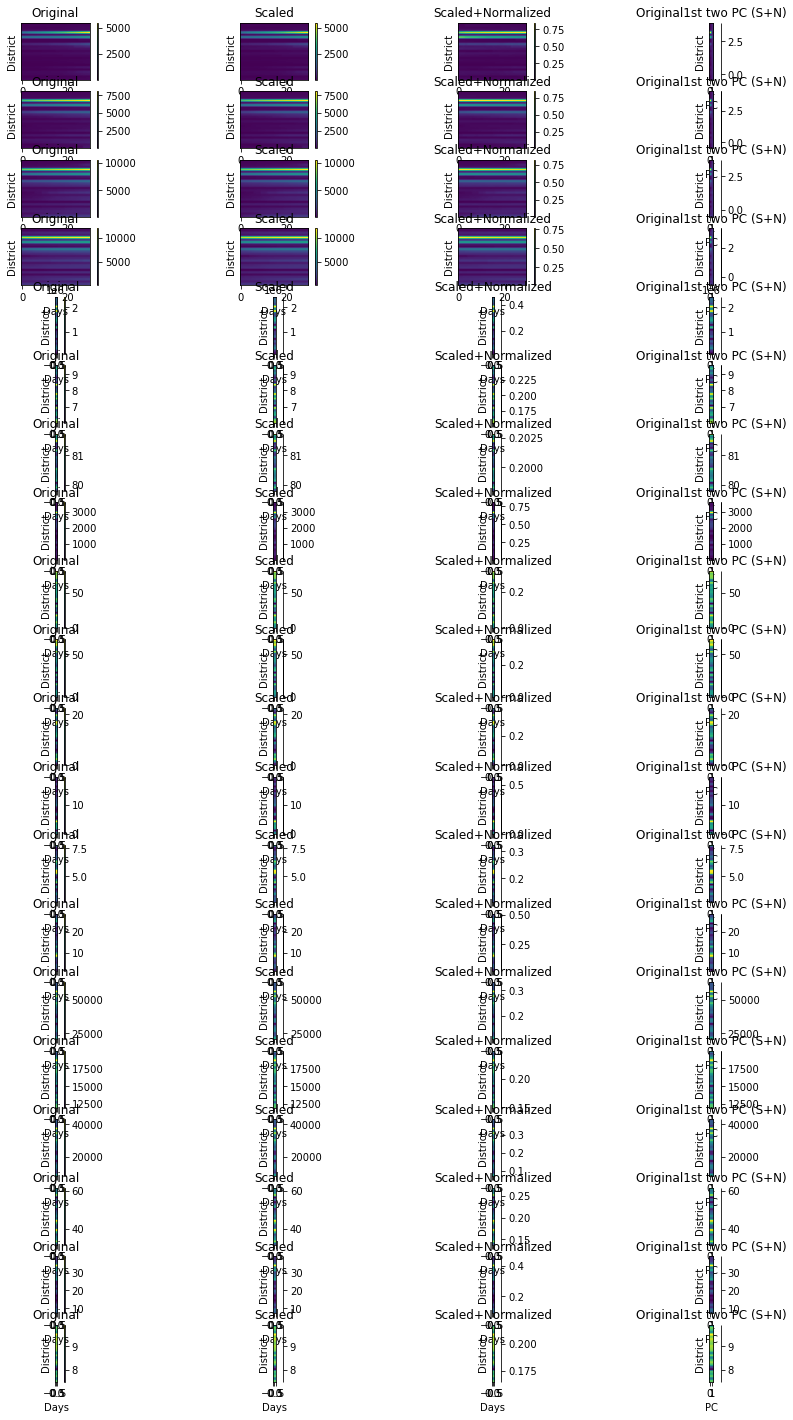

In [78]:
from mpl_toolkits.axes_grid1 import make_axes_locatable
from sklearn.preprocessing import MinMaxScaler,StandardScaler,normalize
from sklearn.decomposition import PCA 



if scaler_type == "original":
    scaler = None
if scaler_type == "standard":
    scaler = StandardScaler()
if scaler_type == "minmax":
    scaler = MinMaxScaler()

pca = PCA(n_components = 2) 



data_to_cluster_names = ["Dec", "Jan","Feb","Mar"]
data_to_cluster = []
for i in range(len(epicurve_seg)):
    data_to_cluster.append(epicurve_seg[i])
    
features_fillna = features.fillna(0).values
for i in range(features_fillna.shape[1]):
    data_to_cluster.append(features_fillna[:,i].reshape((-1,1)))
    data_to_cluster_names.append(features.columns[i])

X_original = data_to_cluster

X_scaled=[]
X_normalized=[]
X_two_PC = []

fig, axes = plt.subplots(nrows=len(X_original), ncols=4, figsize=(15, 25))
for i in range(len(X_original)):
    if scaler == None:
        X_scaled.append(X_original[i])  
    else:
        if is_regionwise:
            X_scaled.append(scaler.fit_transform(X_original[i].T).T)
        else:
            shape = X_original[i].shape
            X_scaled.append(scaler.fit_transform(X_original[i].reshape(-1,1)).reshape(shape))
    if is_regionwise:
        X_normalized.append(normalize(X_scaled[-1].T).T)
    else:
        shape = X_scaled[-1].shape
        X_normalized.append(normalize(X_scaled[-1].reshape(1,-1)).reshape(shape))

    
    if X_original[i].shape[1]!=1:
        X_principal = pca.fit_transform(X_normalized[-1]) 
        X_principal = pd.DataFrame(X_principal) 
        X_principal.columns = ['P1', 'P2'] 
        X_two_PC.append(X_principal)
    else:
        X_principal = pd.concat([pd.Series(X_original[i].reshape(-1)),pd.Series(X_original[i].reshape(-1))],axis=1) 
        X_principal.columns = ['P1', 'P2'] 
        X_two_PC.append(X_principal)
#     X_embedded = TSNE(n_components=2).fit_transform(X)

    ax = axes[i,0]
    ax.set_xlabel("Days", axes=ax),ax.set_ylabel("District", axes=ax),ax.set_title("Original")
    my_imshow(X_original[i], ax)

    ax = axes[i,1]
    ax.set_xlabel("Days", axes=ax),ax.set_ylabel("District", axes=ax),ax.set_title("Scaled")
    my_imshow(X_scaled[-1],ax)

    ax = axes[i,2]
    ax.set_xlabel("Days", axes=ax),ax.set_ylabel("District", axes=ax),ax.set_title("Scaled+Normalized")
    my_imshow(X_normalized[-1],ax)

    ax = axes[i,3]
    ax.set_xlabel("PC", axes=ax),ax.set_ylabel("District", axes=ax),ax.set_title("Original1st two PC (S+N)")
    my_imshow(X_two_PC[-1],ax)

finalize_figure("scaling.jpg")

X_cluster = X_scaled



In [79]:
data_to_cluster_names

['Dec',
 'Jan',
 'Feb',
 'Mar',
 'Population',
 'Lat',
 'Lon',
 'Population density',
 'Labour(Total %)',
 'Labour(Skilled %)',
 'Labour(Unskilled %)',
 'Labour(Agri %)',
 'Unemployment rate',
 'Poverty rate',
 'Expenses(Total)',
 'Expenses(Food)',
 'Expenses(Non-food)',
 'Expenses(Food/Non-food)',
 'Internet usage(%)',
 'Education(Median years)']

In [80]:
dpmc = pd.Series(daily_cases.mean(axis=1), name="Mean Daily Per Million")
names = pd.Series(features.index, name="District")
state_data = pd.concat([names, dpmc], 1)
print(state_data)

# plt.figure(figsize=(3,5))
# plt.scatter(features["Lon"].values,features["Lat"].values)

   District  Mean Daily Per Million
0       AMP                   2.224
1       ANU                   4.304
2       BAD                  11.184
3       BAT                   3.952
4       COL                 194.608
5       GAL                  18.048
6       GAM                 100.880
7       HAM                   5.056
8       JAF                   3.368
9       KAL                  47.312
10      KAN                  31.776
11      KEG                  11.880
12      KIL                   0.968
13      KUR                  18.672
14      MAN                   2.112
15      MON                   4.232
16      MTL                   7.696
17      MTR                  13.488
18      MUL                   0.264
19      NUW                   9.784
20      POL                   1.720
21      PUT                   8.944
22      RAT                  20.600
23      TRI                   3.952
24      VAN                   2.984


In [81]:
state_data['Mean Daily Per Million']

0       2.224
1       4.304
2      11.184
3       3.952
4     194.608
5      18.048
6     100.880
7       5.056
8       3.368
9      47.312
10     31.776
11     11.880
12      0.968
13     18.672
14      2.112
15      4.232
16      7.696
17     13.488
18      0.264
19      9.784
20      1.720
21      8.944
22     20.600
23      3.952
24      2.984
Name: Mean Daily Per Million, dtype: float64

In [82]:
a = [[0,2,2,2,3,1,3,0,0,1,1,1,0,1,0,0,2,2,0,1,0,1,1,0,0] ,[2,1,1,1,0,3,0,1,1,3,3,3,2,3,2,1,1,3,2,3,2,3,3,1,2] ,[0,3,3,3,2,1,2,3,3,2,2,1,0,1,0,3,3,1,0,1,0,1,1,3,3] ,[1,1,0,1,3,0,3,1,1,0,0,0,2,0,2,1,0,0,2,0,2,0,0,1,1] ,[1,0,0,1,3,0,3,1,1,3,3,0,2,3,2,1,1,0,2,0,1,0,0,1,2] ,[0,1,0,0,2,2,3,0,2,2,2,3,1,3,1,1,0,2,1,3,1,0,3,0,1] ,[2,2,2,2,1,2,0,0,0,0,0,1,2,0,3,2,1,1,3,2,0,0,2,0,1] ,[2,2,2,1,0,2,0,0,1,1,0,0,1,1,3,2,3,0,3,2,0,0,1,1,0] ,[1,0,2,3,1,0,3,3,0,1,1,1,1,0,2,1,0,0,2,2,3,1,3,1,2] ,[3,3,0,1,0,1,0,1,3,1,1,1,2,3,0,3,2,0,0,2,2,2,2,0,2] ,[2,0,0,1,1,2,1,3,2,1,2,3,3,1,0,2,3,0,2,0,1,2,1,1,1] ,[1,1,3,2,0,3,0,0,1,0,1,1,3,1,2,1,1,2,2,1,1,0,3,3,0] ,[3,3,3,3,2,3,2,1,1,2,1,1,3,1,0,0,1,1,0,3,1,1,3,3,1] ,[3,1,2,3,0,2,0,2,0,0,3,2,2,2,3,1,3,2,1,3,2,0,1,0,0] ,[3,3,3,1,2,3,2,0,3,2,0,0,3,0,1,1,0,0,1,3,0,0,3,1,0] ,[2,0,2,3,1,0,1,0,2,1,0,0,2,0,3,2,0,0,3,2,0,2,2,3,0] ,[1,1,1,2,3,2,3,2,2,3,3,0,0,1,0,2,1,0,0,0,0,2,1,2,2] ,[1,2,3,1,0,2,0,0,2,0,0,2,1,2,1,3,0,3,1,1,3,3,2,1,2]]

In [83]:
map_labels = a

In [84]:
perm = [[0,1,2,3],
        [0,1,2,3],
        [2,1,0,3],
        [2,1,0,3]]
for i in range(4):
    map_labels[i] = np.array(perm[i])[map_labels[i]]

In [85]:
import branca.colormap as cmp
import io
from PIL import Image

n_months = 4
for i in range(n_months):

    dpmc = pd.Series(map_labels[i], name="Labels")
    names = pd.Series(features.index, name="District")
    state_data = pd.concat([names, dpmc], 1)
    print(state_data)


    state_geo = "../maps/LKA_electrol_districts.geojson"
    step = cmp.StepColormap(
         ['black', 'green', 'blue','red'],
         vmin=0, vmax=3,
         index=[0, 0.5, 1.5, 2.5],  #for change in the colors, not used fr linear
         caption='Color Scale for Map'    #Caption for Color scale or Legend
        )
    m = folium.Map(location=[8,81], zoom_start=7.3)

    label_dict = state_data.set_index('District')['Labels']
    folium.GeoJson(state_geo, name="geojson",
        style_function=lambda feature: {
            'fillColor': step(label_dict[feature['properties']['electoralDistrictCode']]),
            'fillOpacity':0.8,
            'color': 'black',       #border color for the color fills
            'weight': 1,            #how thick the border has to be
            'dashArray': '5, 3'  #dashed lines length,space between them
    }).add_to(m)
    
    # folium.Choropleth(
    #     geo_data=state_geo,
    #     name="choropleth",
    #     data=state_data,
    #     columns=["District", "Labels"],
    #     key_on="properties.electoralDistrictCode",
    #     fill_color="YlGn",
    #     fill_opacity=0.7,
    #     line_opacity=0.2,
    #     legend_name="Mean Covid-19 Cases",
        
    # ).add_to(m)
    
    step.add_to(m)     #adds colorscale or legend

    folium.LayerControl().add_to(m)

    

    img_data = m._to_png(2)
    img = Image.open(io.BytesIO(img_data))
    img.save(f'{data_to_cluster_names[i]}_image.png')

   District  Labels
0       AMP       0
1       ANU       2
2       BAD       2
3       BAT       2
4       COL       3
5       GAL       1
6       GAM       3
7       HAM       0
8       JAF       0
9       KAL       1
10      KAN       1
11      KEG       1
12      KIL       0
13      KUR       1
14      MAN       0
15      MON       0
16      MTL       2
17      MTR       2
18      MUL       0
19      NUW       1
20      POL       0
21      PUT       1
22      RAT       1
23      TRI       0
24      VAN       0
   District  Labels
0       AMP       2
1       ANU       1
2       BAD       1
3       BAT       1
4       COL       0
5       GAL       3
6       GAM       0
7       HAM       1
8       JAF       1
9       KAL       3
10      KAN       3
11      KEG       3
12      KIL       2
13      KUR       3
14      MAN       2
15      MON       1
16      MTL       1
17      MTR       3
18      MUL       2
19      NUW       3
20      POL       2
21      PUT       3
22      RAT       3


In [86]:
def fixed_aspect_ratio(ax,ratio):
    '''
    Set a fixed aspect ratio on matplotlib plots 
    regardless of axis units
    '''
    xvals,yvals = ax.get_xlim(),ax.get_ylim()

    xrange = xvals[1]-xvals[0]
    yrange = yvals[1]-yvals[0]
    ax.set_aspect(ratio*(xrange/yrange), adjustable='box')

# ALL

D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by setting batch_size >= 1024 or by setting the environment variable OMP_NUM_THREADS=1
  f"MiniBatchKMeans is known to have a memory leak on "
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\cluster\_kmeans.py:888: UserWarning: MiniBatchKMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can prevent it by 

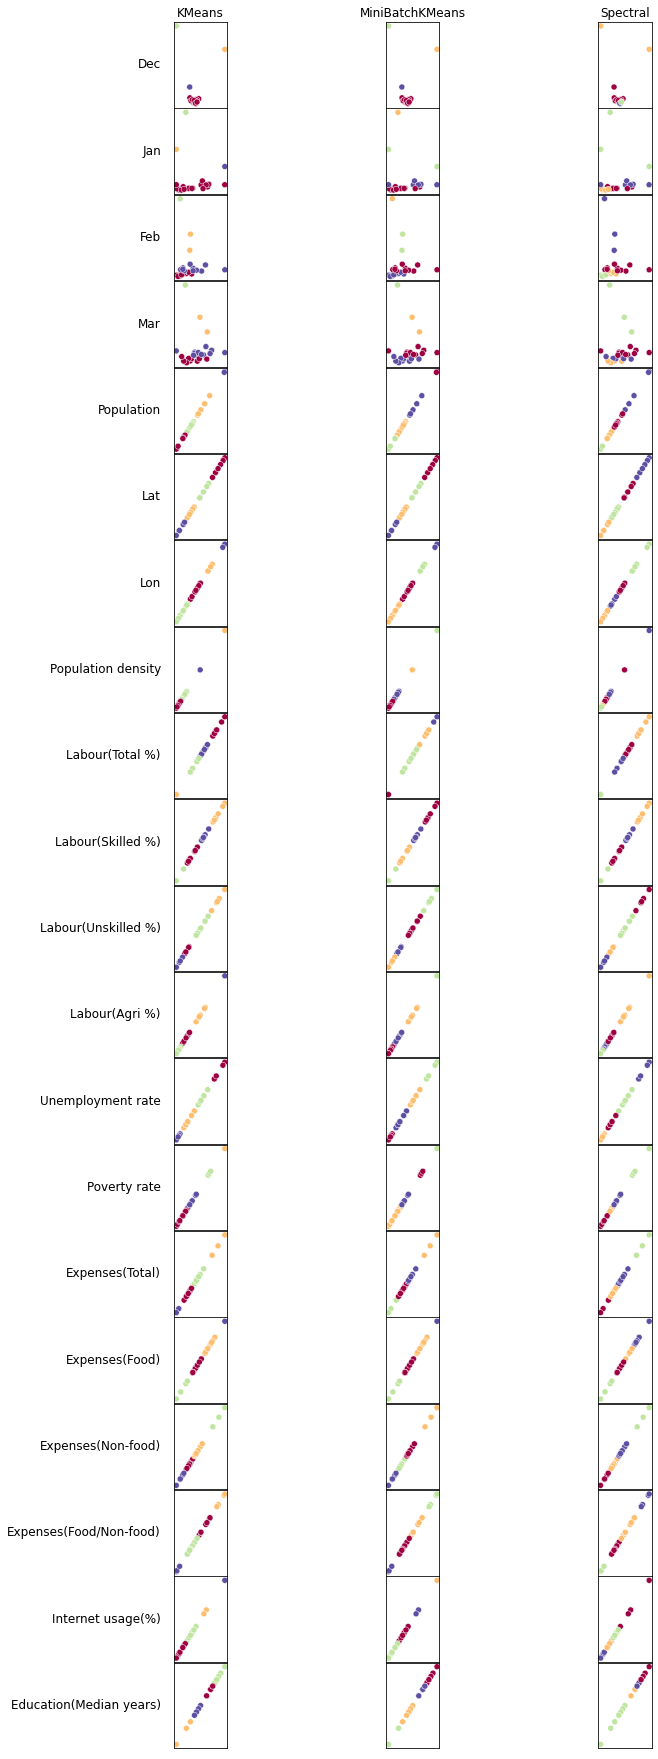

In [87]:
X_cluster = X_scaled

# ============
# Set up cluster parameters
# ============
# plt.figure(figsize=(15, 25))
fig, axes = plt.subplots(nrows=len(X_original), ncols=3, figsize=(15, 25))
plt.subplots_adjust(left=.02, right=.6, bottom=.001, top=.96, wspace=.05, hspace=.01)

plot_num = 1

labels = []

for i_dataset, X_i in enumerate(X_cluster):
    # update parameters with dataset-specific values
    params = algo_params.copy()

    # estimate bandwidth for mean shift
    bandwidth = cluster.estimate_bandwidth(X_i, quantile=params['quantile'])

    # connectivity matrix for structured Ward
    connectivity = kneighbors_graph(
        X_i, n_neighbors=params['n_neighbors'], include_self=False)
    # make connectivity symmetric
    connectivity = 0.5 * (connectivity + connectivity.T)

    # ============
    # Create cluster objects
    # ============
    km = cluster.KMeans(n_clusters = params['n_clusters'], init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
    ms = cluster.MeanShift(bandwidth=bandwidth, bin_seeding=True)
    two_means = cluster.MiniBatchKMeans(n_clusters=params['n_clusters'])
    
    ward = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage='ward', connectivity=connectivity)
    average_linkage = cluster.AgglomerativeClustering(n_clusters=params['n_clusters'], linkage="average", affinity="cityblock", connectivity=connectivity)
    
    spectral = cluster.SpectralClustering(n_clusters=params['n_clusters'], eigen_solver='arpack', affinity="nearest_neighbors")
    dbscan = cluster.DBSCAN(eps=params['eps'])
    optics = cluster.OPTICS(min_samples=params['min_samples'], xi=params['xi'], min_cluster_size=params['min_cluster_size'])
    
    affinity_propagation = cluster.AffinityPropagation(damping=params['damping'], preference=params['preference'])
    birch = cluster.Birch(n_clusters=params['n_clusters'])
    
    gmm = mixture.GaussianMixture(n_components=params['n_clusters'], covariance_type='full')

    clustering_algorithms = (
        ('KMeans', km),
        ('MiniBatchKMeans', two_means),
#         ('AffinityProp', affinity_propagation),
#         ('MeanShift', ms),
        ('Spectral', spectral),
#         ('Ward', ward),
#         ('Agglomerative', average_linkage),
#         ('DBSCAN', dbscan),
#         ('OPTICS', optics),
#         ('Birch', birch),
#         ('GMM', gmm)
    )
    labels.append([])
    i_algo = -1
    for name, algorithm in clustering_algorithms:
        i_algo += 1
        t0 = time.time()

        # catch warnings related to kneighbors_graph
        with warnings.catch_warnings():
            warnings.filterwarnings(
                "ignore",
                message="the number of connected components of the " +
                "connectivity matrix is [0-9]{1,2}" +
                " > 1. Completing it to avoid stopping the tree early.",
                category=UserWarning)
            warnings.filterwarnings(
                "ignore",
                message="Graph is not fully connected, spectral embedding" +
                " may not work as expected.",
                category=UserWarning)
            algorithm.fit(X_i)

        t1 = time.time()
        if hasattr(algorithm, 'labels_'):
            y_pred = algorithm.labels_.astype(int)
        else:
            y_pred = algorithm.predict(X_i)
        labels[-1].append(y_pred)
        
        # creating DataFrame from results to plot
        tmp = pd.DataFrame()
        tmp["Code"] = features.index.values
        tmp["Lon"] = features["Lon"].values
        tmp["Lat"] = features["Lat"].values
        tmp["Clu"] = y_pred
        tmp["P1"] = X_two_PC[i_dataset]["P1"]
        tmp["P2"] = X_two_PC[i_dataset]["P2"]
        tmp.set_index("Code")
        
        if len(tmp["Clu"].unique()) == 1:
            palette = None
        else:
            palette = sns.color_palette("Spectral", as_cmap=True) 

        try:
            ax = axes[i_dataset,i_algo]
#             sns.scatterplot(data=tmp, x='Lon', y='Lat', hue='Clu',  legend="none",
#                 palette=palette,ax=ax) 
            sns.scatterplot(data=tmp, x='P2', y='P1', hue='Clu',  legend="none",
                        palette=palette,ax=ax )    
        except:
            pass
        ax.set_xticks(())
        ax.set_yticks(())
        ax.set_xlabel("")
        ax.set_ylabel("")
        fixed_aspect_ratio(ax,1.6)
        plot_num += 1
pad = 5
cols = [x[0] for x in clustering_algorithms]
for ax, col in zip(axes[0], cols):
    ax.annotate(col, xy=(0.5, 1), xytext=(0, pad),
                xycoords='axes fraction', textcoords='offset points',
                size='large', ha='center', va='baseline')

for ax, row in zip(axes[:,0], data_to_cluster_names):
    ax.annotate(row, xy=(0, 0.5), xytext=(-ax.yaxis.labelpad - pad, 0),
                xycoords=ax.yaxis.label, textcoords='offset points',
                size='large', ha='right', va='center')
plt.show()

labels = np.array(labels)

In [88]:
n_months = labels.shape[0]-features_fillna.shape[1]

# Cluster centers

In [89]:
cluster_centers = []
for month_i in range(n_months):
    _X_i = X_original[month_i]
    cluster_centers.append([])
    for alg_i in range(labels.shape[1]):
        _labels = labels[month_i,alg_i]
        centers = []
        for i in range(np.max(_labels)+1):
            
            centers.append(np.mean(_X_i[_labels==i]))
        cluster_centers[-1].append(centers)
cluster_centers = np.array(cluster_centers)

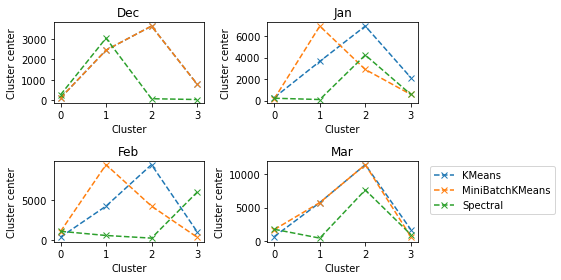

In [90]:
for month_i in range(n_months):
    plt.subplot(2,2,month_i+1)
    for alg_i in range(labels.shape[1]):
        plt.plot(cluster_centers[month_i,alg_i,:], 'x--', label=clustering_algorithms[alg_i][0])
    plt.title(data_to_cluster_names[month_i])
    plt.xlabel("Cluster")
    plt.ylabel("Cluster center")
plt.tight_layout()
plt.legend(bbox_to_anchor=(1.05, 1))
plt.show()
             

# Compare labels

In [91]:
def onehot(x, n_classes):
    b = np.zeros((x.size, n_classes+1))
    b[np.arange(x.size),x] = 1
    return b

def metric(yt,yp,n_classes):
    yt = (yt+1)/n_classes
    yp = (yp+1)/n_classes
    # return sum(yt!=yp)
    # return sum(-yt*np.log(yp))
    # return np.abs(yp - yt*np.log(yp))
    return np.sum((yt-yp)**2)

    yt = onehot(yt,n_classes)
    yp = onehot(yp,n_classes)
    kl = tf.keras.losses.KLDivergence(reduction=tf.keras.losses.Reduction.NONE) # loss = y_true * log(y_true / y_pred)
    return kl(yt,yp).numpy().sum()
    # return yt * np.log(yt / yp)
    

def compare(lt,lp, n_clusters, permute_both=True):
    """
    lt : 1D array of labels (true)
    lp : 1D array of labels (predicted)
    n_clusters: number of clusters in true labels
    """
    lp = lp - np.min(lp)
    best = 1e100
    for mapper in list(itertools.permutations(np.arange(n_clusters))):
        cost = metric(np.array(mapper)[lt], lp, n_clusters)
        best = min(best, cost)
    if permute_both:
        for mapper in list(itertools.permutations(np.arange(n_clusters))):
            cost = metric(lt, np.array(mapper)[lp], n_clusters)
            best = min(best, cost)
    return best

## Algorithms v Demographics

In [92]:

MC_all = 100

all_metrics = []
all_metrics_MC = []

for j in range(features_fillna.shape[1]):
    metrics = []
    for month_i in range(n_months):
        metrics.append([])
        for alg_i in range(labels.shape[1]):
            metrics[-1].append(compare(labels[-(features_fillna.shape[1])+j,alg_i], labels[month_i,alg_i], 4))

    metrics = np.array(metrics).squeeze()
    all_metrics.append(metrics)
    
    metrics = []
    for month_i in range(n_months):
        metrics.append([])
        for alg_i in range(labels.shape[1]):
            _metric = []
            for MC in range(MC_all):
                 _metric.append(compare(np.random.randint(0,4,25), labels[month_i,alg_i], 4, permute_both=False))
            metrics[-1].append(np.mean(_metric))
    
    metrics = np.array(metrics).squeeze()
    all_metrics_MC.append(metrics)
    
all_metrics_MC = np.array(all_metrics_MC)
all_metrics = np.array(all_metrics)

In [93]:
all_metrics_MC.shape

(16, 4, 3)

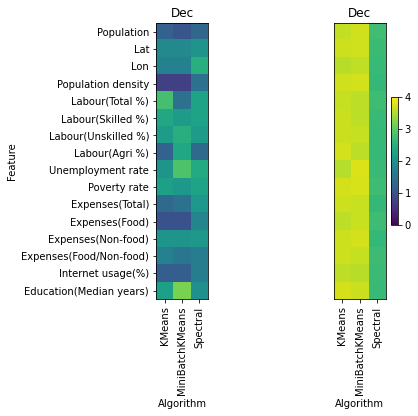

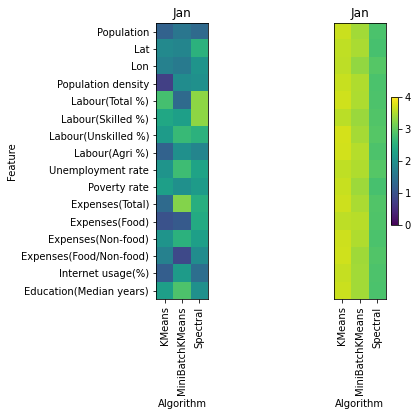

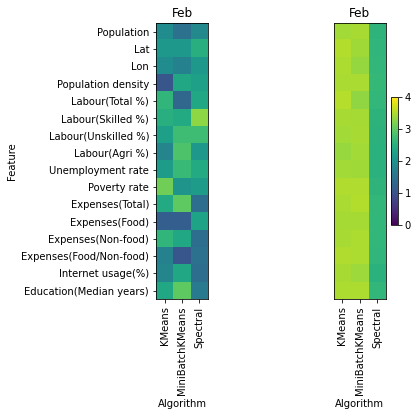

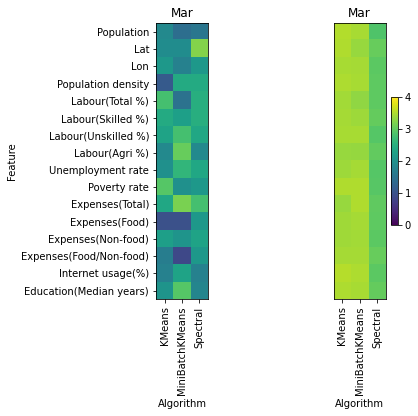

In [94]:
for i in  range(all_metrics.shape[1]):
    
    plt.subplots_adjust(left=.02, right=.68, bottom=.001, top=.96, wspace=.05, hspace=.01)
    
    plt.subplot(121)
    plt.imshow(all_metrics[:,i,:], vmin=0, vmax=4)
    
    plt.title(data_to_cluster_names[i])
    plt.xlabel('Algorithm')
    plt.ylabel('Feature')
    plt.yticks([i for i in range(len(features.columns))],features.columns)
    plt.xticks([i for i in range(len(clustering_algorithms))],[x[0] for x in clustering_algorithms], rotation=90)
    
    plt.subplot(122)
    plt.imshow(all_metrics_MC[:,i,:], vmin=0, vmax=4)
    plt.colorbar(fraction=0.046, pad=0.04)
    plt.title(data_to_cluster_names[i])
    plt.xlabel('Algorithm')
    
    plt.yticks([])
    plt.xticks([i for i in range(len(clustering_algorithms))],[x[0] for x in clustering_algorithms], rotation=90)
    
    plt.show()

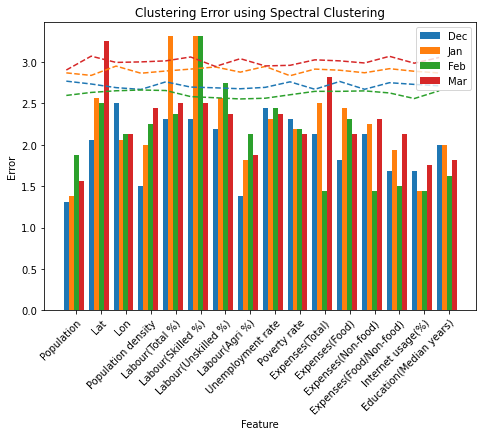

In [95]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(len(features.columns))
w = 0.2
for i in  range(all_metrics.shape[1]):
    ax.bar(X + i*w, all_metrics[:,i,2], width = w, label=data_to_cluster_names[i])
    ax.plot(all_metrics_MC[:,i,2], linestyle='--')
# plt.axhline(y=2, color='r', linestyle='--')
plt.title("Clustering Error using Spectral Clustering")
plt.xlabel('Feature')
plt.ylabel('Error')
plt.xticks(X+0.4,features.columns, rotation=45, ha="right", rotation_mode="anchor")
plt.legend()
plt.show()
    

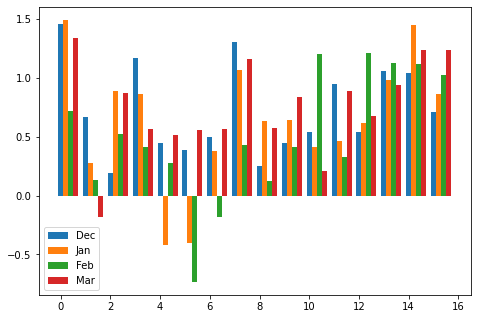

In [96]:
fig = plt.figure()
ax = fig.add_axes([0,0,1,1])
X = np.arange(len(features.columns))
w = 0.2
for i in  range(all_metrics.shape[1]):
    ax.bar(X + i*w, all_metrics_MC[:,i,2]-all_metrics[:,i,2], width = w, label=data_to_cluster_names[i])
plt.legend()
plt.show()

## Months v Months

In [97]:
all_metrics = []
all_metrics_MC = []

for month_j in range(n_months):
    metrics = []
    for month_i in range(labels.shape[0]-features_fillna.shape[1]):
        metrics.append([])
        for alg_i in range(labels.shape[1]):
            metrics[-1].append(compare(labels[month_j,alg_i], labels[month_i,alg_i], 4))

    metrics = np.array(metrics).squeeze()
    all_metrics.append(metrics)
    
    metrics = []
    for month_i in range(n_months):
        metrics.append([])
        for alg_i in range(labels.shape[1]):
            _metric = []
            for MC in range(MC_all):
                 _metric.append(compare(np.random.randint(0,4,25), labels[month_i,alg_i], 4))
            metrics[-1].append(np.mean(_metric))
    
    metrics = np.array(metrics).squeeze()
    all_metrics_MC.append(metrics)
    
all_metrics_MC = np.array(all_metrics_MC)
all_metrics = np.array(all_metrics)

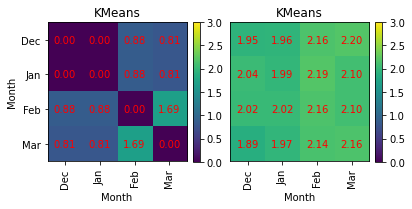

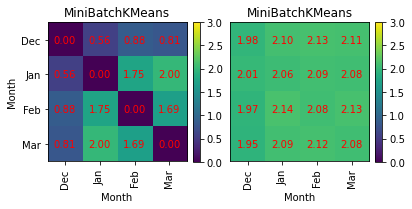

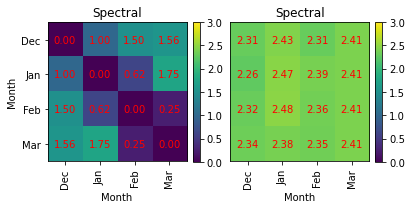

In [98]:
for i in  range(all_metrics.shape[2]):
    
#     plt.subplots_adjust(left=.02, right=.98, bottom=.001, top=.96, wspace=.05, hspace=.01)
    
    plt.subplot(121)
    plt.imshow(all_metrics[:,:,i], vmin=0, vmax=3)
    ax = plt.gca()
    # Loop over data dimensions and create text annotations.
    for x in range(all_metrics[:,:,i].shape[0]):
        for y in range(all_metrics[:,:,i].shape[1]):
            text = ax.text(y, x, "{:.2f}".format(all_metrics[:,:,i][x, y]), ha="center", va="center", color="r")
    plt.title(data_to_cluster_names[i])
    plt.xlabel('Month')
    plt.ylabel('Month')
    plt.title(clustering_algorithms[i][0])
    plt.yticks([i for i in range(n_months)],data_to_cluster_names[:n_months])
    plt.xticks([i for i in range(n_months)],data_to_cluster_names[:n_months], rotation=90)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.subplot(122)
    plt.imshow(all_metrics_MC[:,:,i], vmin=0, vmax=3)
    ax = plt.gca()
    # Loop over data dimensions and create text annotations.
    for x in range(all_metrics_MC[:,:,i].shape[0]):
        for y in range(all_metrics_MC[:,:,i].shape[1]):
            text = ax.text(y, x, "{:.2f}".format(all_metrics_MC[:,:,i][x, y]), ha="center", va="center", color="r")
    plt.xlabel('Month')
    plt.title(clustering_algorithms[i][0])
    plt.yticks([])
    plt.xticks([i for i in range(n_months)],data_to_cluster_names[:n_months], rotation=90)
    plt.colorbar(fraction=0.046, pad=0.04)
    
    plt.show()

# Number of points in each cluster

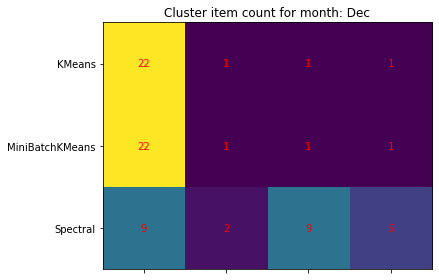

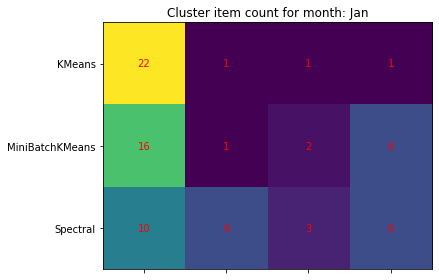

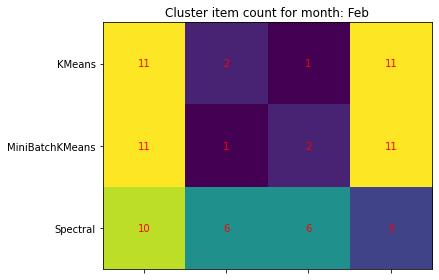

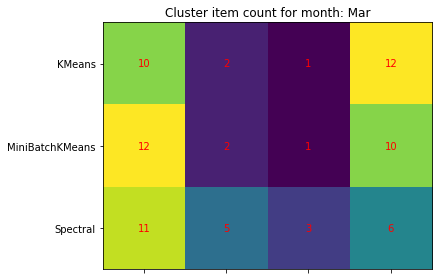

In [99]:
def get_count(arr):
    tmp = []
    for i in np.unique(arr):
        tmp.append(np.sum(arr==i))
    return tmp



for i in range(n_months):
    fig,ax = plt.subplots()
    count = []
    for a in range(labels.shape[1]):
        count.append(get_count(labels[i,a,:]))

    width = 0
    for tmp in count:
        width = max(width, len(tmp))
    for a in range(len(count)):
        while len(count[a])!=width:
            count[a].append(0)
    count = np.array(count)
    im = ax.imshow(count)

    ax.set_xticks(np.arange(width))
    ax.set_yticks(np.arange(len(clustering_algorithms)))
    ax.set_xticklabels([])
    ax.set_yticklabels([x[0] for x in clustering_algorithms])

    # Rotate the tick labels and set their alignment.
    plt.setp(ax.get_xticklabels(), rotation=45, ha="right", rotation_mode="anchor")

    # Loop over data dimensions and create text annotations.
    for x in range(count.shape[0]):
        for y in range(count.shape[1]):
            text = ax.text(y, x, count[x, y], ha="center", va="center", color="r")

    ax.set_title(f"Cluster item count for month: {data_to_cluster_names[i]}")
    fig.tight_layout()
    plt.show()



# K-Means

D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\cluster\_kmeans.py:882: UserWarning: KMeans is known to have a memory leak on Windows with MKL, when there are less chunks than available threads. You can avoid it by setting the environment variable OMP_NUM_THREADS=1.
  f"KMeans is known to have a memory leak on Windows "
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\ipykernel_launcher.py:27: RuntimeWarning: invalid value encountered in true_divide
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\

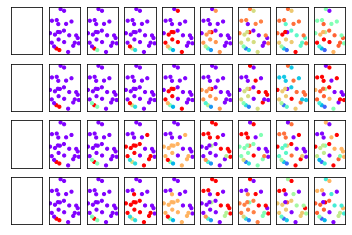

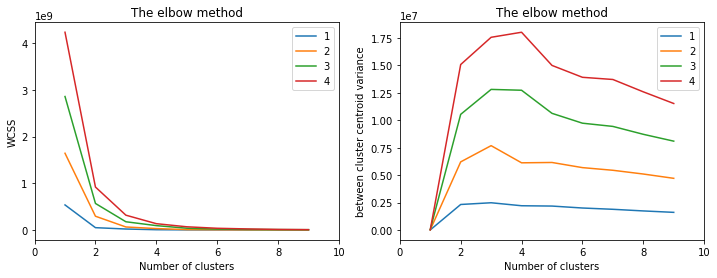

In [100]:
''' 
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
k-means clustering
>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>>
'''
import matplotlib.cm as cm
from sklearn.cluster import KMeans

plt.figure(0,figsize=(12,4))
plt.figure(1)
strs = []
plot_num = 1
for k in range(segments):
    wcss = []
    cvar = []

    for i in range(1, 10):
        kmeans1 = KMeans(n_clusters = i, init = 'k-means++', max_iter = 300, n_init = 10, random_state = 0)
        kmeans1.fit(epicurve_seg[k,:,:])
        cvar.append(np.var(kmeans1.cluster_centers_))
        wcss.append(kmeans1.inertia_)  

        plt.figure(1)
        plt.subplot(segments, 9, plot_num)
        y_pred = kmeans1.labels_.astype(int)
        X_embedded = features[['Lat',"Lon"]].values
        plt.scatter(X_embedded[:, 0], X_embedded[:, 1], s=10, color=cm.rainbow(y_pred/np.max(y_pred)))
        plt.xticks(())
        plt.yticks(())
        plot_num += 1

    strs.append(str(k+1))
    #Plotting the results onto a line graph, allowing us to observe 'The elbow'
    plt.figure(0)
    plt.subplot(1,2,1)
    plt.plot(range(1, 10), wcss)
    plt.subplot(1,2,2)
    plt.plot(range(1, 10), cvar)

for n in range(2):
    plt.subplot(1,2,n+1)
    plt.xlim([0,10])
    plt.legend(strs)
    plt.title('The elbow method')
    plt.xlabel('Number of clusters')
    if n==0:  
        plt.ylabel('WCSS') #within cluster sum of squares
    else:
        plt.ylabel('between cluster centroid variance') #between cluster variance
plt.show()


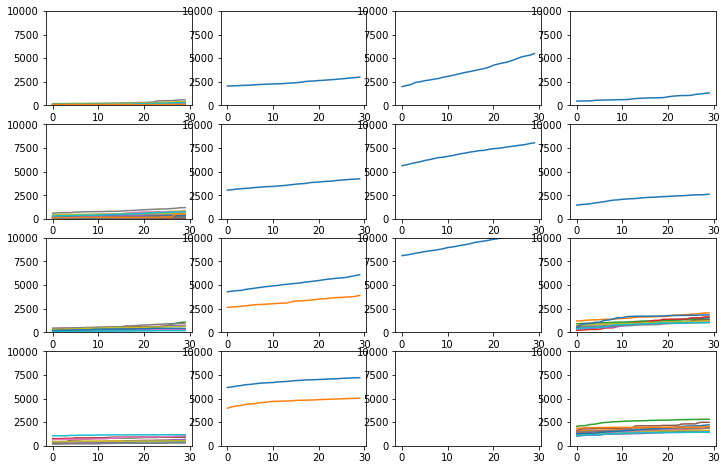

In [101]:

import matplotlib.cm as cm
from sklearn.cluster import KMeans

clusters = 4

plt.figure(0, figsize=(segments*3, clusters*2))
plot_num = 1
for k in range(segments):
    kmeans2 = KMeans(n_clusters=clusters, init='k-means++', max_iter=300, n_init=10, random_state=0)
    kmeans2.fit(epicurve_seg[k,:,:])
    labels = kmeans2.labels_
    for c in  range(clusters):
        g = labels == c
        plt.subplot(segments, clusters, plot_num)
        plt.plot(epicurve_seg[k,g,:].T)
        plt.ylim([0,10000])
        plot_num += 1
plt.show()

D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\cluster\_kmeans.py:294: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectr

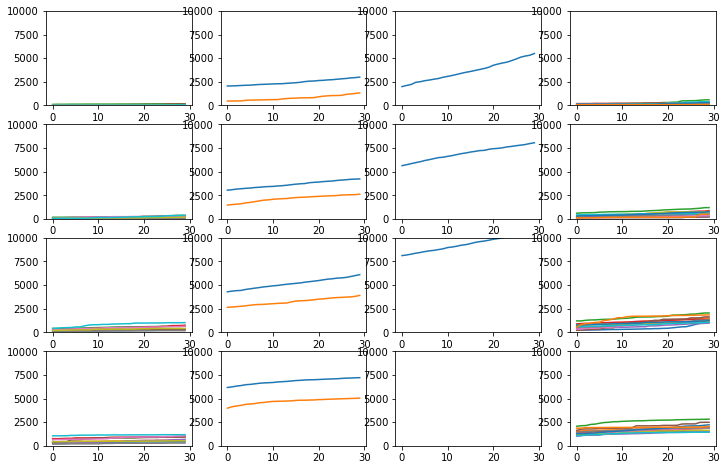

In [102]:
clusters = 4
from sklearn.cluster import SpectralClustering


plt.figure(0, figsize=(segments*3, clusters*2))
plot_num = 1
for k in range(segments):
    spek2 = SpectralClustering(n_clusters=clusters, random_state=0)
    spek2.fit(epicurve_seg[k,:,:])
    labels = kmeans2.labels_
    for c in  range(clusters):
        g = labels == c
        plt.subplot(segments, clusters, plot_num)
        plt.plot(epicurve_seg[k,g,:].T)
        plt.ylim([0,10000])
        plot_num += 1
plt.show()

# Spectral Clustering

D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\cluster\_kmeans.py:294: ConvergenceWarning: Number of distinct clusters (3) found smaller than n_clusters (4). Possibly due to duplicate points in X.
  ).fit(X, sample_weight=sample_weight)
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"
D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectr

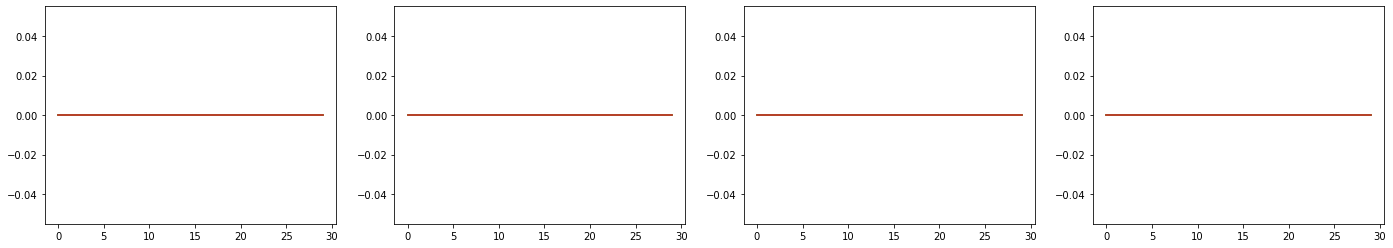

D:\ProgramData\Anaconda3\envs\cov19\lib\site-packages\sklearn\manifold\_spectral_embedding.py:245: UserWarning: Graph is not fully connected, spectral embedding may not work as expected.
  warnings.warn("Graph is not fully connected, spectral embedding"


array([2, 2, 3, 0, 2, 0, 1, 0, 2, 2, 3, 2, 0, 2, 0, 1, 3, 2, 1, 3, 3, 1,
       2, 3, 1])

In [103]:
from sklearn.cluster import SpectralClustering

clusters = 4
centroids = np.zeros([segments, clusters, seg_length])

plt.figure(figsize=(segments*6,4))
for k in range(segments):
    spek2 = SpectralClustering(n_clusters = clusters, random_state = 0)
    spek2.fit(epicurve_seg[k,:,:])
    # centroids[k,:,:] = spek2.cluster_centers_
    plt.subplot(1,segments,k+1)
    plt.plot(centroids[k,:,:].T)
plt.show()

# checking for segment 1 only
spek3 = SpectralClustering(n_clusters = clusters, random_state = 0)
spek3.fit(epicurve_seg[2,:,:])
# centroids3 = spek3.cluster_centers_
labels3 = spek3.labels_


labels3